solafune:夜間光データから土地価格を予測ベースモデル(by cha_kabu)
https://qiita.com/cha_kabu/items/679ff02f6386f8e3034a
の写経

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from ptitprince import RainCloud

from pandas_profiling import ProfileReport

print(os.getcwd())

/src/Solafune/夜間光データから土地価格を予測/src


In [2]:
INPUT_DIR = '/src/Solafune/夜間光データから土地価格を予測/data/inputs/'
OUTPUT_DIR = '/src/Solafune/夜間光データから土地価格を予測/data/outputs/'
NB_NAME = 'nb003'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'TrainDataSet.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'EvaluationData.csv'))

In [3]:
print(f'train:{train_df.shape}')
print(f'test :{test_df.shape}')

train:(21883, 5)
test :(13860, 4)


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21883 entries, 0 to 21882
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PlaceID           21883 non-null  int64  
 1   Year              21883 non-null  int64  
 2   AverageLandPrice  21883 non-null  float64
 3   MeanLight         21883 non-null  float64
 4   SumLight          21883 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 854.9 KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PlaceID    13860 non-null  int64  
 1   Year       13860 non-null  int64  
 2   MeanLight  13860 non-null  float64
 3   SumLight   13860 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 433.2 KB


<AxesSubplot:xlabel='AverageLandPrice', ylabel='Count'>

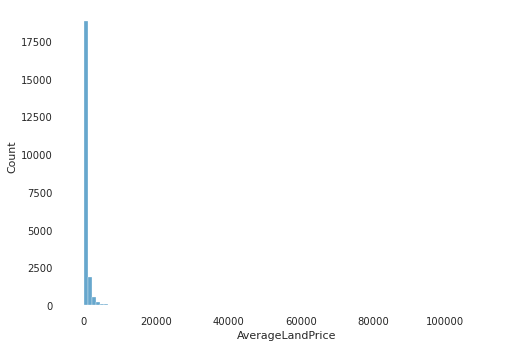

In [6]:
sns.histplot(data=train_df, x='AverageLandPrice', bins=100)

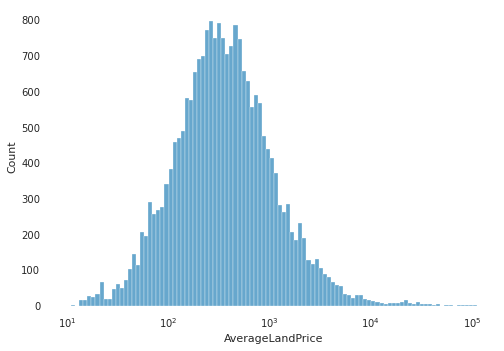

In [7]:
sns.histplot(data=train_df, x='AverageLandPrice', log_scale=10, bins=100)
plt.show()

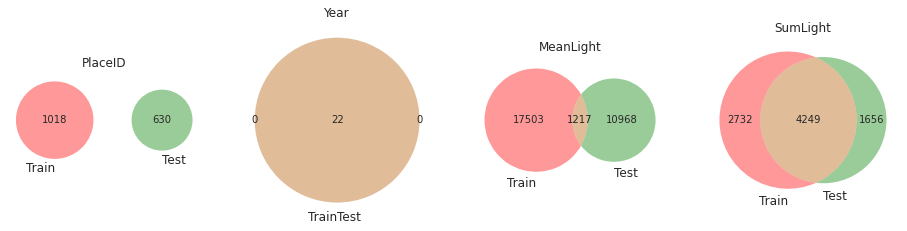

In [8]:
fig, axes = plt.subplots(figsize=(16, 4), ncols=4)

for c, ax in zip(test_df.columns, axes.ravel()):
    venn2(
        subsets = (set(train_df[c].unique()), set(test_df[c].unique())),
        set_labels = ('Train', 'Test'),
        ax = ax
    )
    ax.set_title(c)
    
#fig.tight_layout()

In [9]:
train_df['is_train'] = 1
test_df['is_train'] = 0

whole_df = pd.concat([train_df.drop('AverageLandPrice', axis=1), test_df], ignore_index=True)

In [10]:
whole_df

,PlaceID,Year,MeanLight,SumLight,is_train
0,1128,1993,57.571430,403.0,1
1,1128,1994,62.714287,439.0,1
2,1128,1995,61.857143,433.0,1
3,1128,1996,61.714287,432.0,1
4,1128,1997,62.857143,440.0,1
...,...,...,...,...,...
35738,693,2009,4.869198,1154.0,0
35739,693,2010,7.839663,1858.0,0
35740,693,2011,6.189873,1467.0,0
35741,693,2012,7.230452,1757.0,0


In [11]:
whole_df.groupby('is_train')['PlaceID'].describe().iloc[:,3:]

,min,25%,50%,75%,max
is_train,,,,,
0,3.0,446.0,867.0,1279.0,1662.0
1,1.0,395.5,810.0,1223.0,1660.0


<AxesSubplot:xlabel='Year', ylabel='Count'>

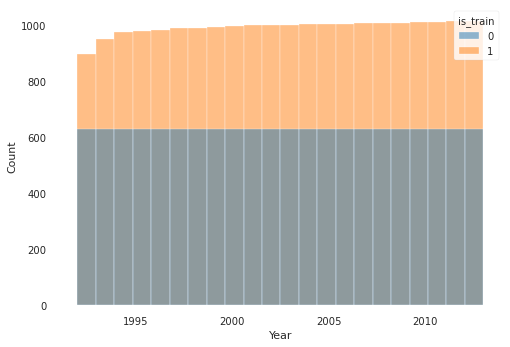

In [12]:
sns.histplot(data=whole_df, x='Year', hue='is_train', bins=22)

<AxesSubplot:xlabel='MeanLight', ylabel='Count'>

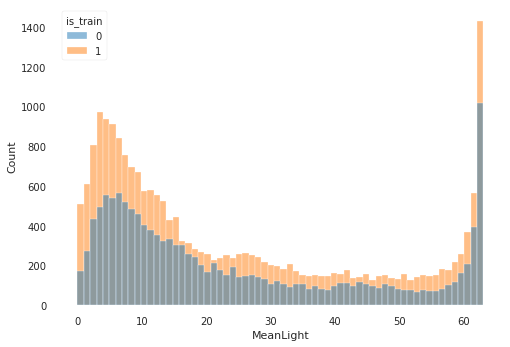

In [14]:
sns.histplot(data=whole_df, x='MeanLight', hue='is_train', bins=64)

<AxesSubplot:xlabel='SumLight', ylabel='Count'>

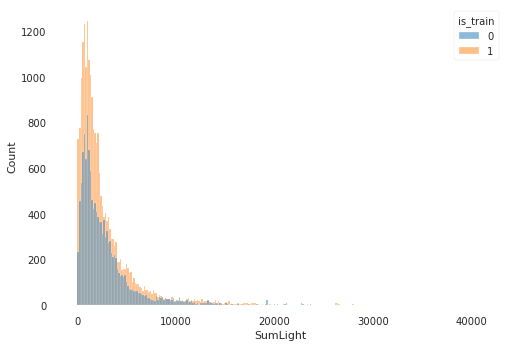

In [17]:
sns.histplot(data=whole_df, x='SumLight', hue='is_train')

<AxesSubplot:xlabel='AverageLandPrice', ylabel='PlaceID'>

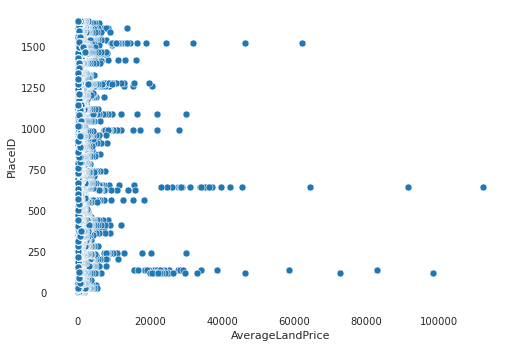

In [18]:
sns.scatterplot(data=train_df, x='AverageLandPrice', y='PlaceID')

<AxesSubplot:xlabel='AverageLandPrice', ylabel='Year'>

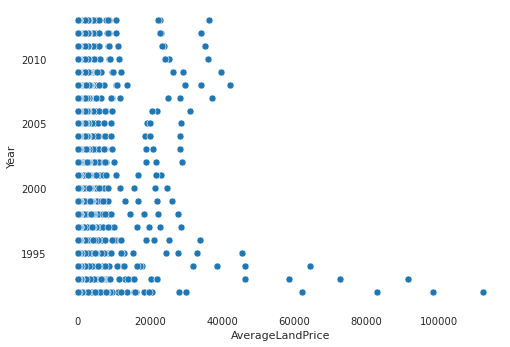

In [19]:
sns.scatterplot(data=train_df, x='AverageLandPrice', y='Year')

<AxesSubplot:xlabel='MeanLight', ylabel='AverageLandPrice'>

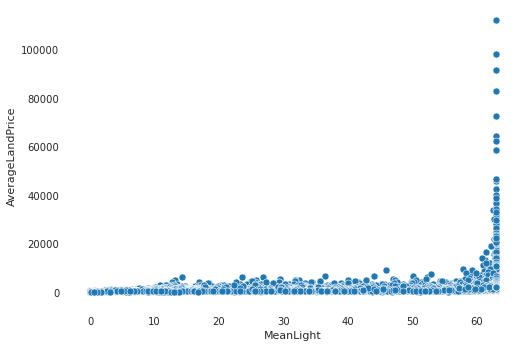

In [20]:
sns.scatterplot(data=train_df, x='MeanLight', y='AverageLandPrice')

<AxesSubplot:xlabel='SumLight', ylabel='AverageLandPrice'>

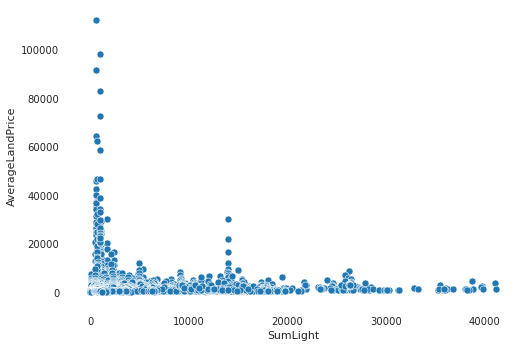

In [21]:
sns.scatterplot(data=train_df, x='SumLight', y='AverageLandPrice')

In [22]:
train_df['area'] = train_df['SumLight'] / train_df['MeanLight']

<AxesSubplot:xlabel='AverageLandPrice', ylabel='area'>

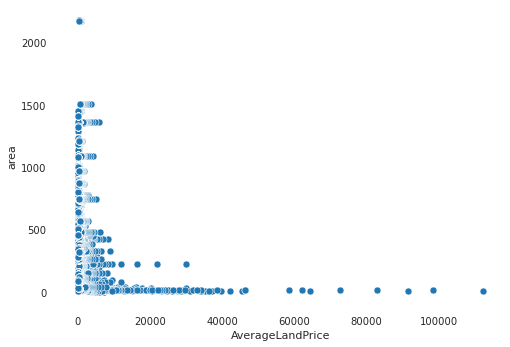

In [23]:
sns.scatterplot(data=train_df, x='AverageLandPrice', y='area')

In [28]:
import category_encoders as ce

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'TrainDataSet.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'EvaluationData.csv'))
whole_df = pd.concat([train_df.drop('AverageLandPrice', axis=1), test_df], ignore_index=True)

In [29]:
#countencoding
enc = ce.CountEncoder(cols='PlaceID')
whole_df['count_PlaceID'] = enc.fit_transform(whole_df)['PlaceID']

# 面積
whole_df['area'] = whole_df['SumLight'] / whole_df['MeanLight']
# 面積なのに同じ地域でも年次によって小数点以下でズレが生じるため、地域ごとの中央値に置き換える
_mapping = whole_df.groupby('PlaceID')['area'].median()
whole_df['area'] = whole_df['PlaceID'].map(_mapping)

# 面積について、SumLightとMeanLightがともに0な地域があり、NaNになってしまうので0で補完する
whole_df['area'] = whole_df['area'].fillna(0)

# MeanLightが63とった回数を特徴量に
_mapping = whole_df[whole_df['MeanLight']==63].groupby('PlaceID').size()
whole_df['count63'] = whole_df['PlaceID'].map(_mapping)

whole_df['count63'] = whole_df['count63'].fillna(0)

In [45]:
def range_diff(x):
    return x.max() - x.min()

def third_quartile(x):
    return x.quantile(0.75)
def first_quartile(x):
    return x.quantile(0.25)
def quartile_range(x):
    return x.quantile(0.75) - x.quantile(0.25)

In [46]:
whole_df

,PlaceID,Year,MeanLight,SumLight,count_PlaceID,area,count63
0,1128,1993,57.571430,403.0,21,7.000000,0.0
1,1128,1994,62.714287,439.0,21,7.000000,0.0
2,1128,1995,61.857143,433.0,21,7.000000,0.0
3,1128,1996,61.714287,432.0,21,7.000000,0.0
4,1128,1997,62.857143,440.0,21,7.000000,0.0
...,...,...,...,...,...,...,...
35738,693,2009,4.869198,1154.0,22,243.000001,0.0
35739,693,2010,7.839663,1858.0,22,243.000001,0.0
35740,693,2011,6.189873,1467.0,22,243.000001,0.0
35741,693,2012,7.230452,1757.0,22,243.000001,0.0


In [47]:
whole_df.groupby('PlaceID')[['MeanLight', 'SumLight']].agg('min')

,MeanLight,SumLight
PlaceID,,
1,6.654412,905.0
2,41.154762,6914.0
3,6.647059,226.0
4,28.584158,5774.0
5,41.631580,791.0
...,...,...
1658,57.666668,1197.0
1659,6.824512,4900.0
1660,3.468208,600.0


In [49]:
cols = ['MeanLight', 'SumLight']
aggs = ['min', 'mean', 'median', 'max', 'std', 'skew',
        range_diff, third_quartile, first_quartile, quartile_range]

_whole_df = whole_df.groupby('PlaceID')[cols].agg(aggs).reset_index()

_aggs = []
for agg in aggs:
    if isinstance(agg, str):
        _aggs.append(agg)
    else:
        _aggs.append(agg.__name__)
        
_whole_df.columns = ['PlaceID'] + ["_".join([c, agg]) for c in cols for agg in _aggs]

In [50]:
_whole_df

,PlaceID,MeanLight_min,MeanLight_mean,MeanLight_median,MeanLight_max,MeanLight_std,MeanLight_skew,MeanLight_range_diff,MeanLight_third_quartile,MeanLight_first_quartile,...,SumLight_min,SumLight_mean,SumLight_median,SumLight_max,SumLight_std,SumLight_skew,SumLight_range_diff,SumLight_third_quartile,SumLight_first_quartile,SumLight_quartile_range
0,1,6.654412,9.578523,9.625000,12.708955,1.219428,0.101592,6.054543,10.244485,9.016956,...,905.0,1299.818182,1305.0,1703.0,163.160055,0.004118,798.0,1393.25,1221.25,172.00
1,2,41.154762,48.058121,48.285715,53.911243,3.037256,-0.471909,12.756481,49.413692,47.144344,...,6914.0,8080.590909,8112.0,9111.0,515.614442,-0.436319,2197.0,8301.50,7920.25,381.25
2,3,6.647059,9.794118,9.808824,12.735294,1.582701,-0.064804,6.088235,10.963236,8.669117,...,226.0,333.000000,333.5,433.0,53.811842,-0.064804,207.0,372.75,294.75,78.00
3,4,28.584158,36.124792,35.789603,44.330048,3.660401,-0.062634,15.745890,38.267328,34.143565,...,5774.0,7302.681818,7229.5,8999.0,746.146761,-0.032737,3225.0,7730.00,6897.00,833.00
4,5,41.631580,49.547581,49.368420,55.777779,3.309324,-0.578802,14.146199,51.868420,48.381578,...,791.0,934.181818,935.5,1027.0,57.405522,-0.777810,236.0,972.50,917.50,55.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,1658,57.666668,60.683983,61.214285,62.799999,1.462443,-0.658475,5.133331,61.797620,59.819643,...,1197.0,1265.954545,1264.0,1302.0,32.232012,-0.650078,105.0,1296.75,1247.25,49.50
1644,1659,6.824512,8.799353,8.985376,10.934903,0.992881,-0.145241,4.110391,9.549791,8.060974,...,4900.0,6322.954545,6451.5,7895.0,716.042262,-0.116740,2995.0,6856.75,5811.75,1045.00
1645,1660,3.468208,8.706962,9.014535,11.686047,1.729708,-1.002171,8.217839,9.601156,7.715318,...,600.0,1504.863636,1555.0,2010.0,297.531318,-1.031669,1410.0,1661.00,1334.75,326.25
1646,1661,3.839286,5.236308,5.260714,7.170732,0.806975,0.405563,3.331446,5.875000,4.636716,...,1075.0,1471.681818,1473.0,2058.0,231.608945,0.518022,983.0,1645.00,1319.50,325.50
